In [38]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load dataset
df = pd.read_csv("./sentiment_analysis_data.csv")
df.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [39]:
# List all columns and their data types
df = df.rename(columns={'Index': 'index'})  # Now df has the new column name
print(df.dtypes)

# Number of rows
num_rows = len(df)
# or
num_rows = df.shape[0]

print("\nNumber of rows:", num_rows)

Unnamed: 0     int64
statement     object
status        object
dtype: object

Number of rows: 53043


### 1. Basic Inspection and Data Integrity Checks

In [40]:
# Basic structure and type info
df.info()
print("\n")

# Sample records
df.sample(5)

# Check nulls and empty strings
print("Nulls per column:\n", df.isnull().sum())
print("Empty 'statement' entries:", (df["statement"].astype(str).str.strip() == "").sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Nulls per column:
 Unnamed: 0      0
statement     362
status          0
dtype: int64
Empty 'statement' entries: 0


Class distribution:
 status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


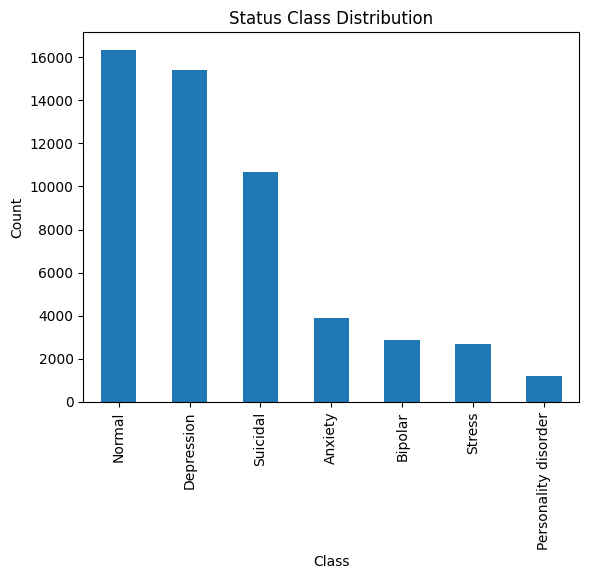

In [41]:
# Check target class distribution
print("Class distribution:\n", df["status"].value_counts())
df["status"].value_counts().plot(kind="bar", title="Status Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

While stress is a normal human response to challenging situations, it is generally not considered a mental disorder in itself. However, chronic or prolonged stress can significantly increase the risk of developing various mental health conditions like anxiety, depression, or post-traumatic stress disorder (PTSD). 

In [42]:
# How many entries are empty strings, NaN, or suspiciously short?
print("Null values per column:\n", df.isnull().sum())
print("\nEmpty strings in 'statement':", (df["statement"] == "").sum())
print("\nStatements with less than 3 words:\n", df["statement"].apply(lambda x: len(str(x).split()) < 3).sum())

# Check for non-string types or values that might be problematic
non_string_mask = ~df["statement"].apply(lambda x: isinstance(x, str))
print(f"\nNon-string 'statement' values: {df[non_string_mask].shape[0]}")
df[non_string_mask]

Null values per column:
 Unnamed: 0      0
statement     362
status          0
dtype: int64

Empty strings in 'statement': 0

Statements with less than 3 words:
 1253

Non-string 'statement' values: 362


Unnamed: 0 statement   status
293           293       NaN  Anxiety
572           572       NaN  Anxiety
595           595       NaN  Anxiety
1539         1539       NaN   Normal
2448         2448       NaN   Normal
...           ...       ...      ...
52838       52838       NaN  Anxiety
52870       52870       NaN  Anxiety
52936       52936       NaN  Anxiety
53010       53010       NaN  Anxiety
53031       53031       NaN  Anxiety

[362 rows x 3 columns]

In [43]:
# Convert to string and handle NaNs
df["statement"] = df["statement"].fillna("").astype(str)

# Normalize text
df["statement"] = df["statement"].str.lower().str.strip()

# Drop empty statements
df = df[df["statement"] != ""]

# Drop statements with less than 3 words
df = df[df["statement"].str.split().str.len() >= 3].reset_index(drop=True)

print(f"Remaining entries: {len(df)}")


Remaining entries: 51790


In [44]:
print(df["status"].value_counts())

# Drop all rows with status 'Stress'
df = df[df["status"] != "Stress"]
print("\n")

# Optional: Reset the index after dropping
df.reset_index(drop=True, inplace=True)

print(df["status"].value_counts())

status
Normal                  15508
Depression              15372
Suicidal                10643
Anxiety                  3828
Bipolar                  2777
Stress                   2585
Personality disorder     1077
Name: count, dtype: int64


status
Normal                  15508
Depression              15372
Suicidal                10643
Anxiety                  3828
Bipolar                  2777
Personality disorder     1077
Name: count, dtype: int64


### 2. Data Visualistion

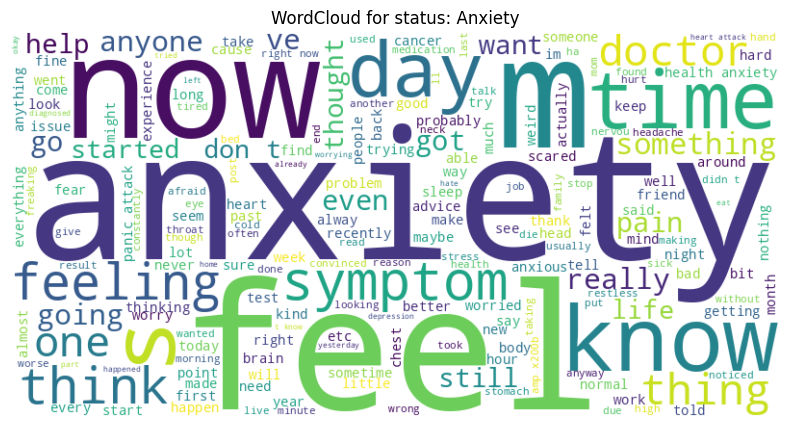

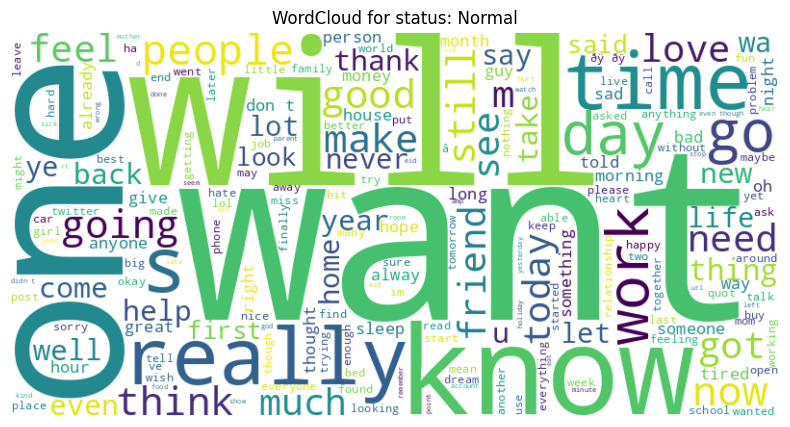

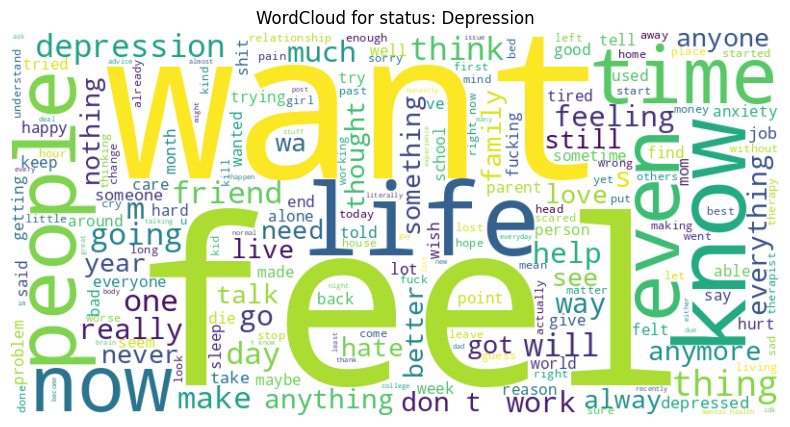

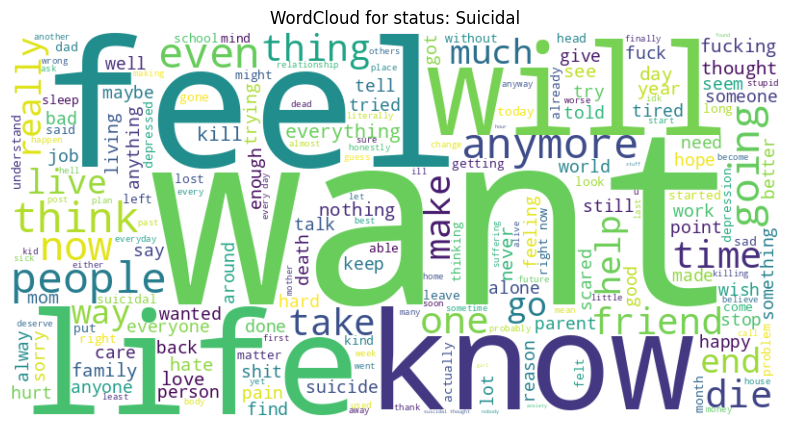

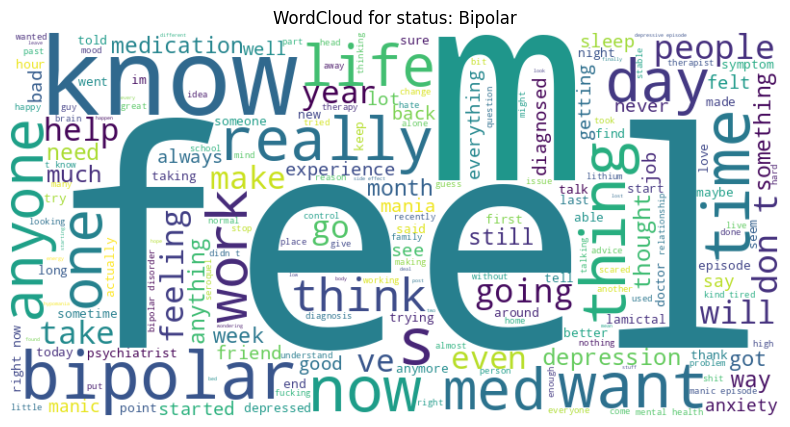

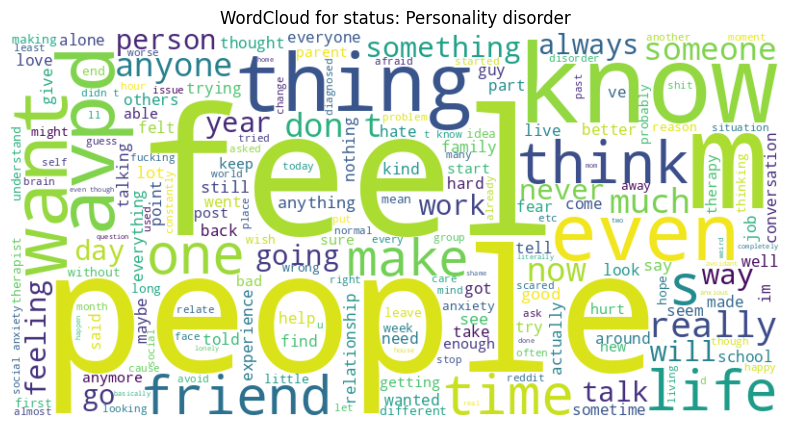

In [45]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate for each class
for label in df["status"].unique():
    text = " ".join(df[df["status"] == label]["statement"])
    generate_wordcloud(text, f"WordCloud for status: {label}")

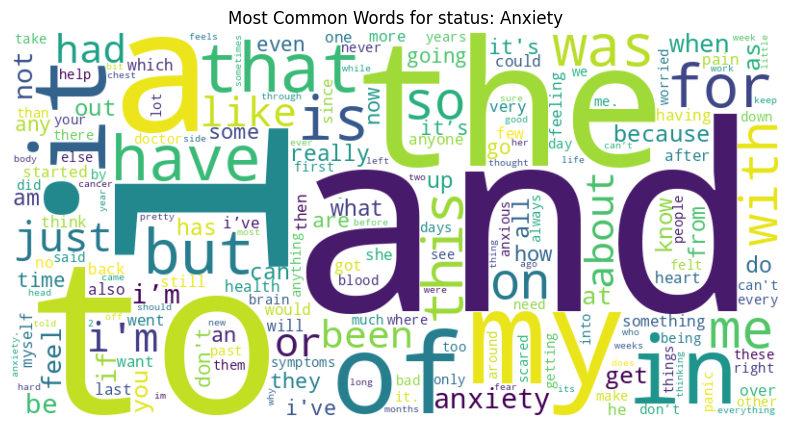


Top words in 'Anxiety':
i: 28136
and: 17197
to: 14531
the: 13278
a: 12774
my: 12739
of: 8462
it: 7109
in: 5938
that: 5827


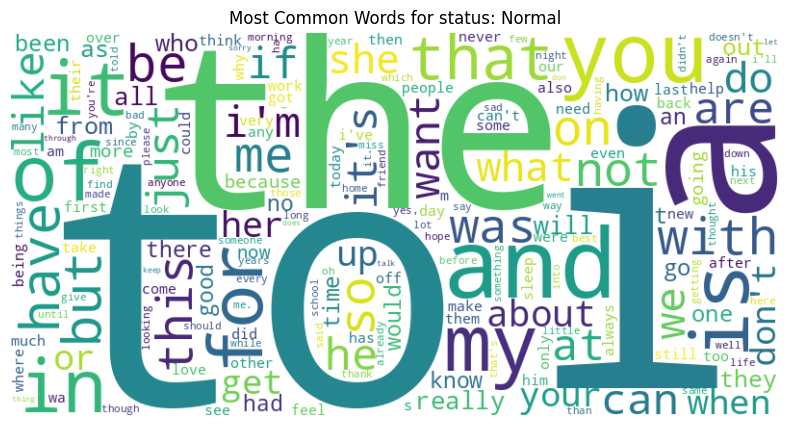


Top words in 'Normal':
i: 9630
to: 8581
the: 8064
a: 5975
and: 5232
you: 3709
is: 3564
my: 3451
of: 3357
it: 3088


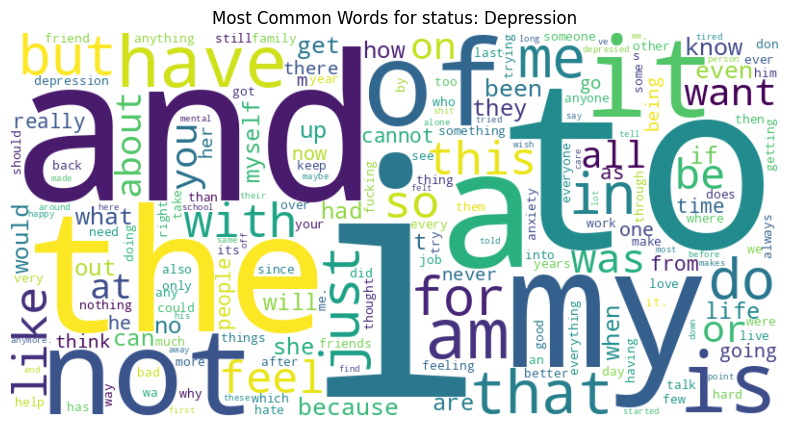


Top words in 'Depression':
i: 188640
to: 85985
and: 77359
the: 51970
my: 51967
a: 50324
not: 36864
of: 36225
it: 33424
is: 31772


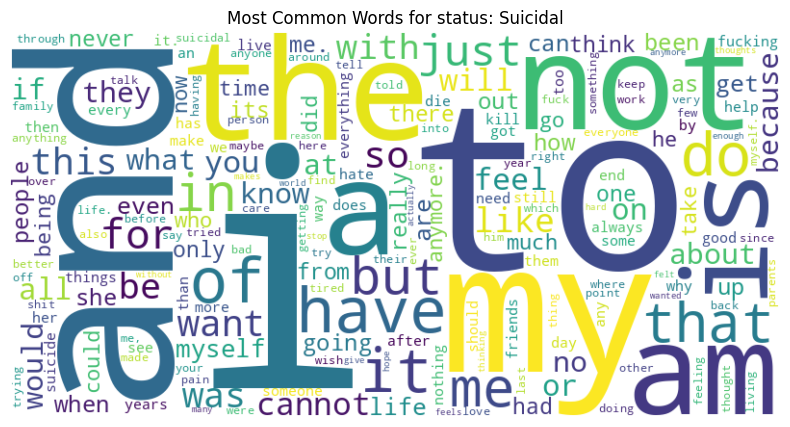


Top words in 'Suicidal':
i: 121609
to: 55734
and: 43841
my: 31627
the: 31119
not: 28252
a: 27703
am: 25208
is: 21301
have: 21281


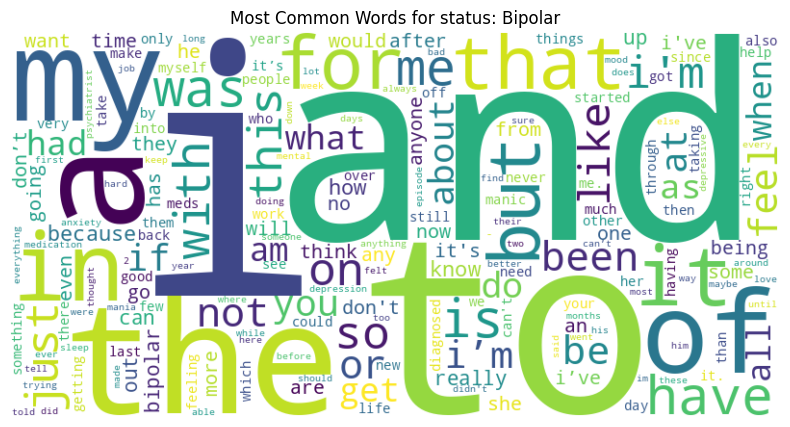


Top words in 'Bipolar':
i: 26193
and: 15587
to: 14342
the: 11015
a: 10647
my: 10246
of: 7661
in: 5129
it: 5096
that: 4967


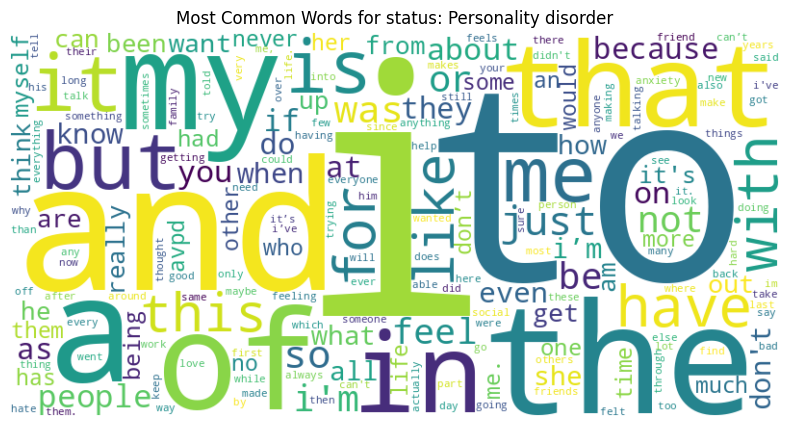


Top words in 'Personality disorder':
i: 10555
to: 6373
and: 5668
the: 3985
a: 3720
my: 3133
of: 3115
that: 2336
in: 2110
but: 1995


In [46]:
def get_top_words(statements, n=10):
    words = " ".join(statements).split()
    return Counter(words).most_common(n)

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud based on most common words (frequency)
def generate_wordcloud_from_counts(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Get top word counts per class and generate word cloud
for label in df["status"].unique():
    words = " ".join(df[df["status"] == label]["statement"]).split()
    word_counts = Counter(words)
    generate_wordcloud_from_counts(word_counts, f"Most Common Words for status: {label}")

    # Optional: Print top 10
    print(f"\nTop words in '{label}':")
    for word, count in word_counts.most_common(10):
        print(f"{word}: {count}")


 ### 3. TF-IDF Feature Extraction for Class Distinction

In [47]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r"[^a-z\s]", '', text)  # Remove punctuation & numbers
    text = re.sub(r"\s+", ' ', text).strip()  # Remove excess whitespace
    return text

df['statement'] = df['statement'].fillna('').astype(str).map(clean_text)

# Enhanced text preprocessing
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')

def enhanced_clean(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    
    # Keep contractions intact but remove other punctuation
    text = re.sub(r"[^\w\s']", ' ', text)
    
    # Convert common contractions to full form
    contractions = {
        "im": "i am", "dont": "do not", "cant": "cannot", 
        "ive": "i have", "isnt": "is not", "didnt": "did not"
    }
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + contraction + r'\b', expansion, text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", ' ', text).strip()
    return text

# Apply enhanced cleaning
df['clean_text'] = df['statement'].fillna('').astype(str).map(enhanced_clean)

# Create extended stopwords list
try:
    stop_words = set(stopwords.words('english'))
except:
    # If NLTK stopwords aren't available
    print("NLTK stopwords not available, using a basic set")
    stop_words = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
                 "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
                 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 
                 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
                 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
                 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
                 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
                 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
                 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
                 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
                 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
                 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y'}

# Add custom stopwords (common but less informative words as shown by previous analysis)
custom_stops = {'i am', 'just', 'like', 'feel', 'really', 'do not', 'want', 'know', 
               'i have', 'time', 'people', 'think', 'going', 'get', 'even', 'always',
               'things', 'one', 'would', 'could', 'much', 'try', 'good', 'day', 'make',
               'lot', 'getting', 'got', 'thing', 'still'}
all_stops = list(stop_words.union(custom_stops))

print(f"Total stopwords: {len(all_stops)}")
print("Sample of cleaned text:")
print(df['clean_text'].head(2))

[nltk_data] Downloading package stopwords to /Users/Dion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total stopwords: 227
Sample of cleaned text:
0                                           oh my gosh
1    trouble sleeping confused mind restless heart ...
Name: clean_text, dtype: object



Top TF-IDF words for 'Anxiety':
im: 0.4959
anxiety: 0.3029
just: 0.2737
like: 0.2661
ive: 0.2202
feel: 0.1857
dont: 0.1666
know: 0.1507
time: 0.1323
really: 0.1305

Top TF-IDF words for 'Bipolar':
im: 0.5219
just: 0.3111
like: 0.2756
feel: 0.2175
ive: 0.2038
dont: 0.2019
bipolar: 0.1687
know: 0.1627
time: 0.1359
really: 0.1358

Top TF-IDF words for 'Depression':
just: 0.4436
like: 0.3487
feel: 0.3160
want: 0.2316
life: 0.2117
know: 0.2068
time: 0.1586
people: 0.1495
really: 0.1376
depression: 0.1211

Top TF-IDF words for 'Normal':
im: 0.3247
just: 0.2864
like: 0.2741
want: 0.2508
dont: 0.2248
really: 0.1899
time: 0.1787
know: 0.1646
good: 0.1485
day: 0.1386

Top TF-IDF words for 'Personality disorder':
im: 0.4420
like: 0.3589
just: 0.3147
people: 0.2630
dont: 0.2604
feel: 0.2348
avpd: 0.1999
know: 0.1686
ive: 0.1397
want: 0.1342

Top TF-IDF words for 'Suicidal':
just: 0.4545
want: 0.3363
like: 0.2875
life: 0.2414
feel: 0.2376
know: 0.2066
people: 0.1482
anymore: 0.1391
going: 0.1349
t

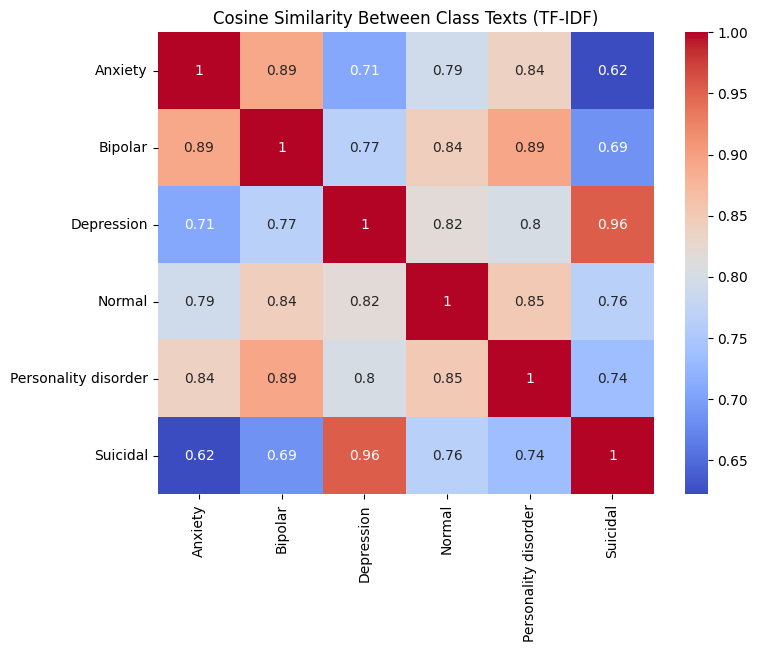

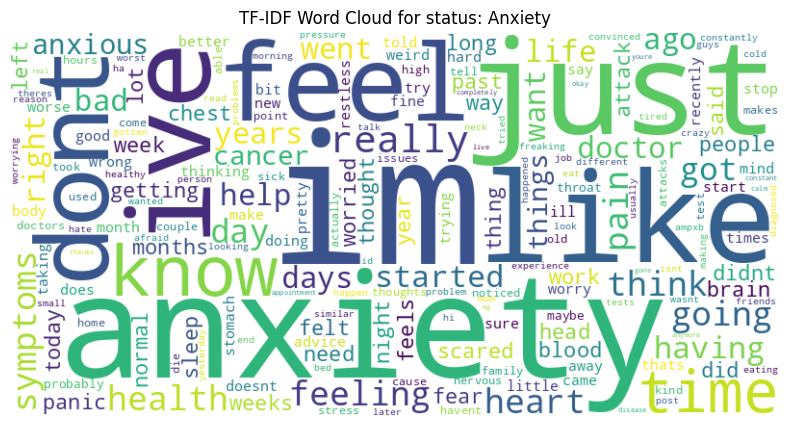

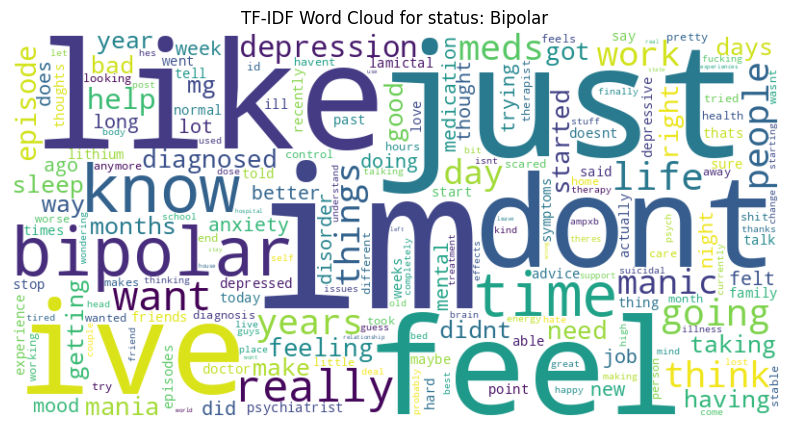

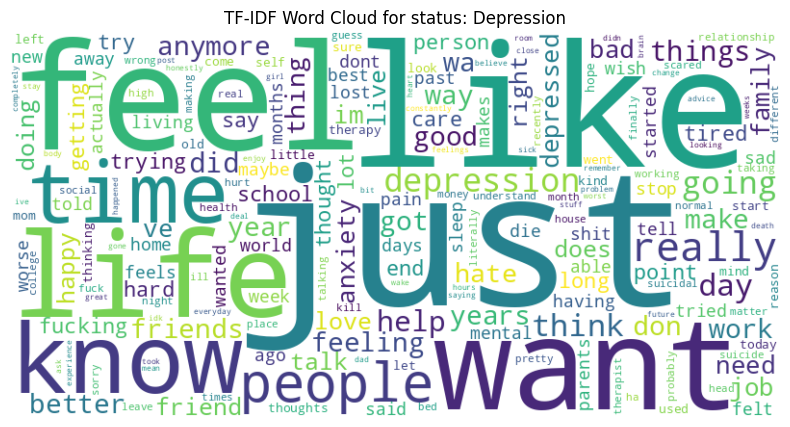

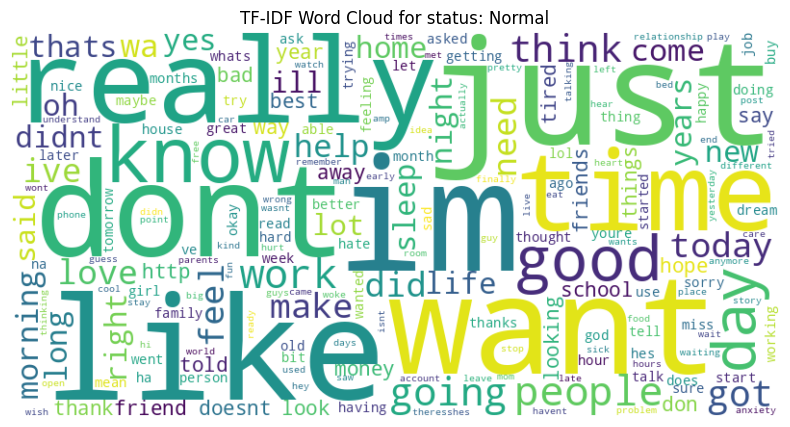

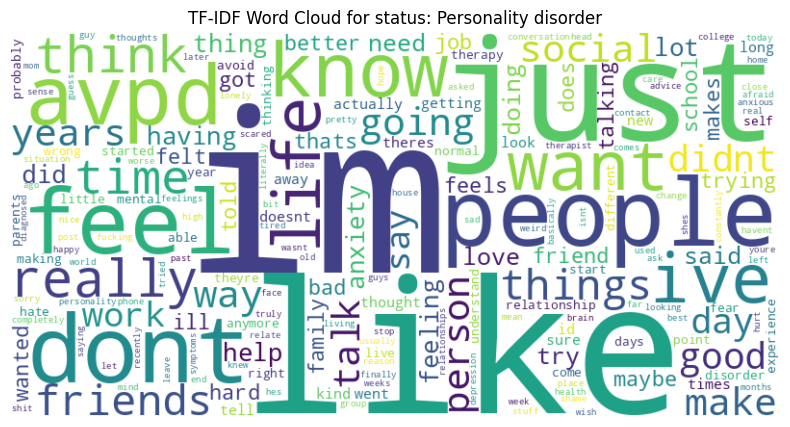

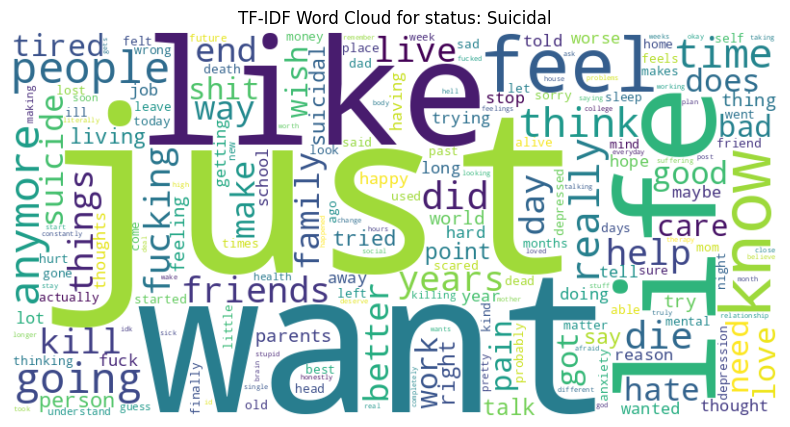

In [48]:
# Group all text by label
class_texts = df.groupby("status")["statement"].apply(lambda x: " ".join(x)).to_dict()

# Build TF-IDF matrix
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
class_corpus = list(class_texts.values())
tfidf_matrix = tfidf.fit_transform(class_corpus)

# Match class names to rows
labels = list(class_texts.keys())

# Show top tf-idf words per class
def top_tfidf_words(tfidf_matrix, labels, vectorizer, top_n=10):
    words = np.array(vectorizer.get_feature_names_out())
    for i, label in enumerate(labels):
        row = tfidf_matrix[i].toarray()[0]
        top_indices = row.argsort()[-top_n:][::-1]
        print(f"\nTop TF-IDF words for '{label}':")
        for idx in top_indices:
            print(f"{words[idx]}: {row[idx]:.4f}")

top_tfidf_words(tfidf_matrix, labels, tfidf)

# Cosine similarity between TF-IDF vectors
cos_sim = cosine_similarity(tfidf_matrix)

# Display similarity matrix
sim_df = pd.DataFrame(cos_sim, index=labels, columns=labels)
print("\nCosine Similarity Matrix Between Classes:")
print(sim_df.round(2))
print("\n")

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(sim_df, annot=True, cmap='coolwarm')
plt.title("Cosine Similarity Between Class Texts (TF-IDF)")
plt.show()

# Generate TF-IDF-weighted word cloud for each class
feature_names = np.array(tfidf.get_feature_names_out())

for i, label in enumerate(labels):
    row = tfidf_matrix[i].toarray()[0]  # TF-IDF scores for the class
    tfidf_scores = {feature_names[j]: row[j] for j in range(len(row)) if row[j] > 0}
    
    # Generate word cloud from TF-IDF scores
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(tfidf_scores)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"TF-IDF Word Cloud for status: {label}")
    plt.axis("off")
    plt.show()



We can see that even though there are improvements in differentiating words used by people aflicted by different statuses, common words like 'im', 'ive', 'just', 'really', people' and 'want' are still in the top tf-tdf words used. This can skew the data if more common words are present amongst two statuses (like how Anxiety and Bipolar have high similarity based on the word 'im') as compared to defining words that people with Anxiety or Bipolar like 'anxious' or 'stable'. Hence more still needs to be done to remove common words.

 ### 4. TF-IDF Feature Extraction with N-grams for Class Distinction

Top TF-IDF N-grams for each class:

Top TF-IDF words for 'Anxiety':
anxiety: 0.4328
back: 0.1471
something: 0.1471
cannot: 0.1423
go: 0.1378
feeling: 0.1359
health: 0.1341
heart: 0.1340
pain: 0.1306
symptoms: 0.1298

Top TF-IDF words for 'Bipolar':
bipolar: 0.2730
cannot: 0.1820
life: 0.1615
anyone: 0.1492
go: 0.1395
meds: 0.1385
years: 0.1360
work: 0.1320
also: 0.1258
manic: 0.1229

Top TF-IDF words for 'Depression':
life: 0.3117
cannot: 0.2309
depression: 0.1783
never: 0.1537
go: 0.1503
help: 0.1357
anything: 0.1255
anymore: 0.1156
work: 0.1150
wa: 0.1146

Top TF-IDF words for 'Normal':
go: 0.2345
work: 0.1804
back: 0.1527
today: 0.1396
see: 0.1340
cannot: 0.1300
need: 0.1284
love: 0.1281
well: 0.1203
help: 0.1151

Top TF-IDF words for 'Personality disorder':
life: 0.2363
cannot: 0.2060
never: 0.1867
friends: 0.1634
anyone: 0.1623
something: 0.1607
someone: 0.1422
go: 0.1343
also: 0.1300
way: 0.1280

Top TF-IDF words for 'Suicidal':
cannot: 0.3367
life: 0.3242
anymore: 0.1869
never: 

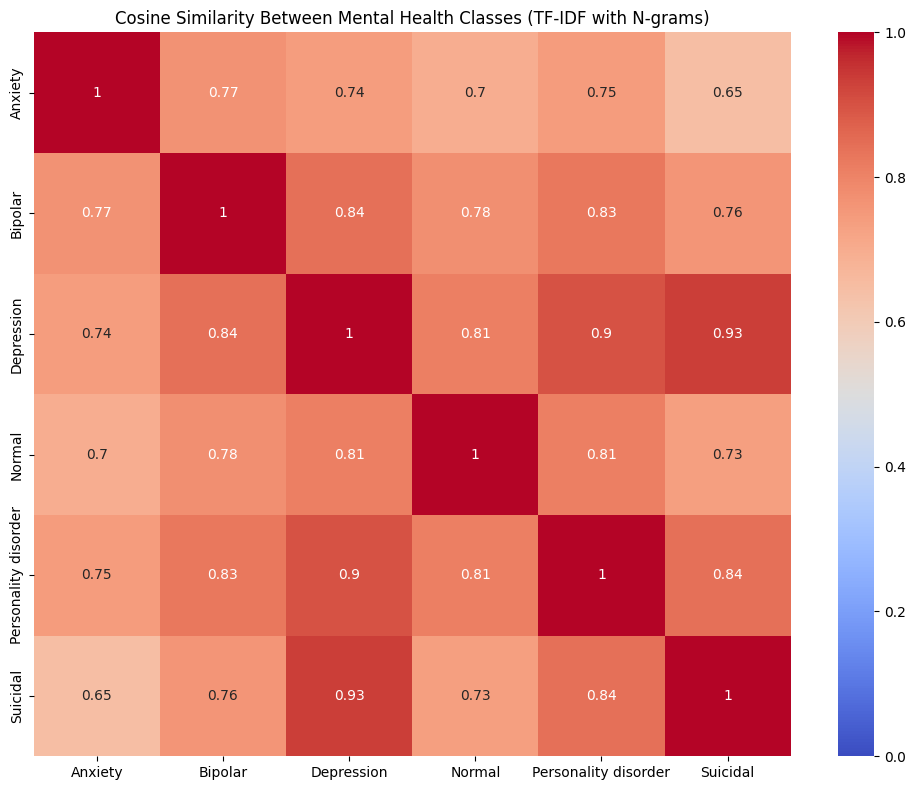

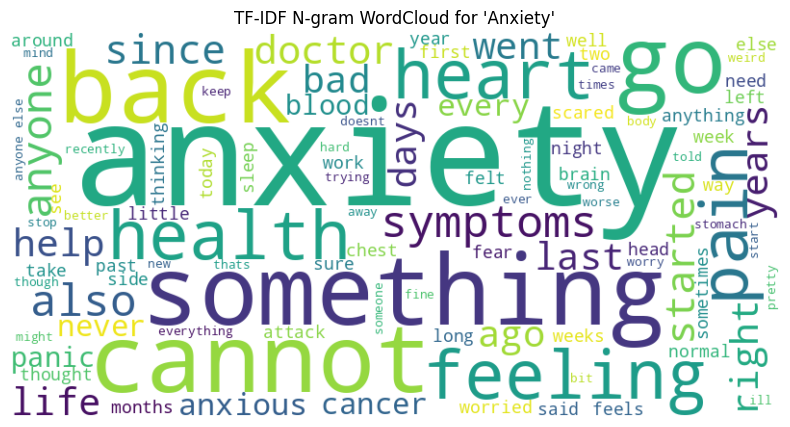

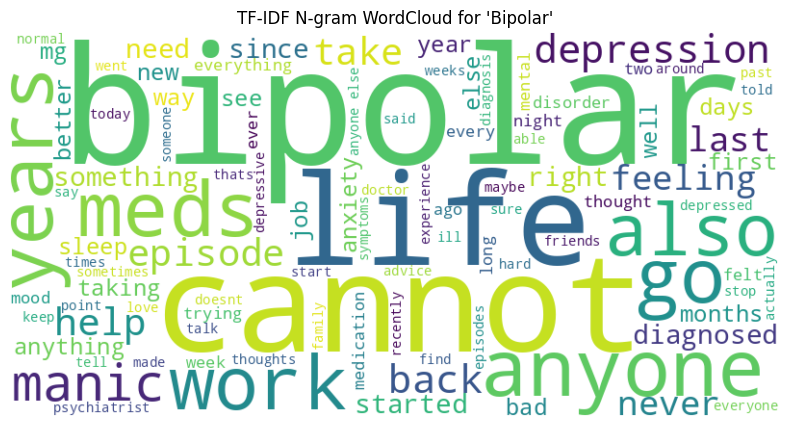

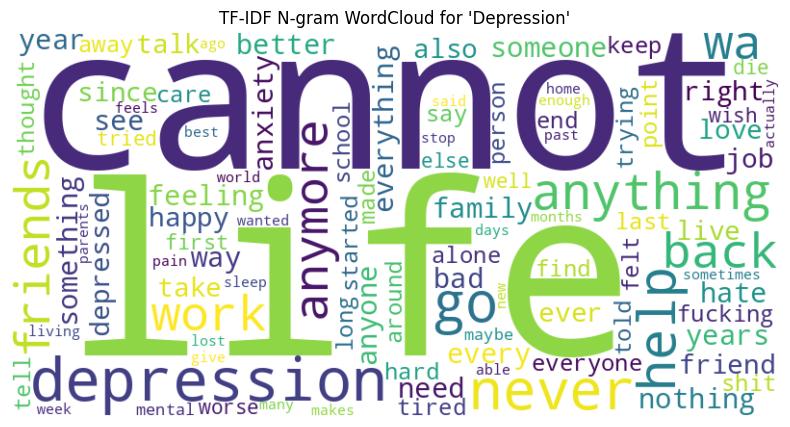

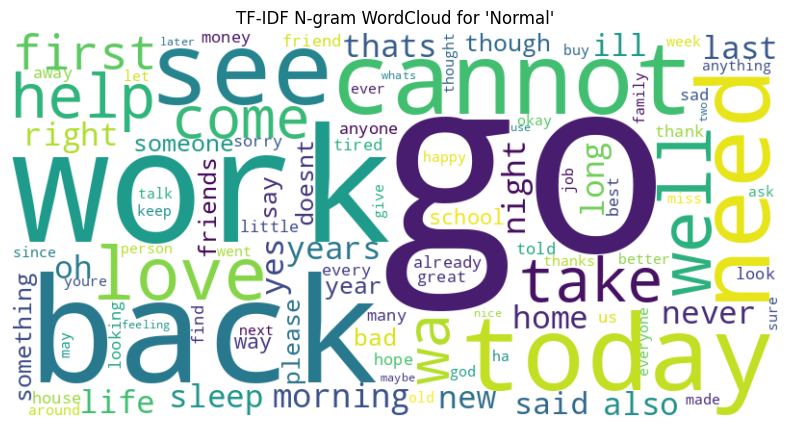

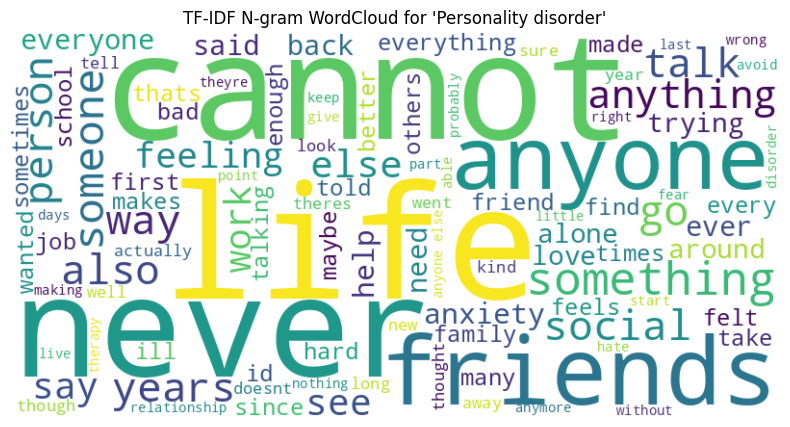

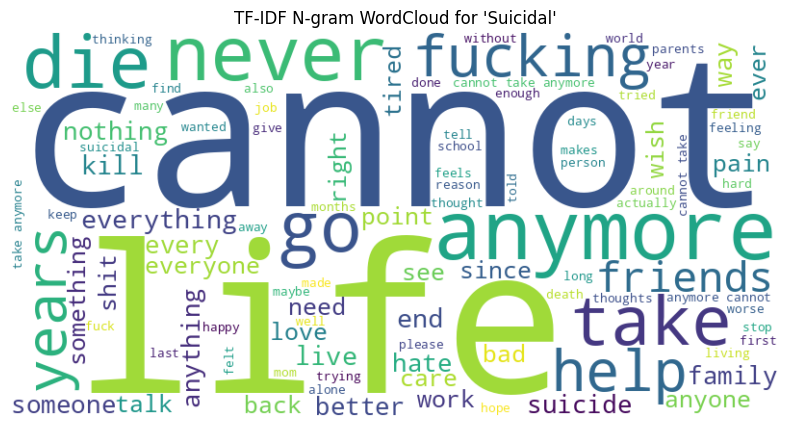

In [49]:
# Group all text by label for TF-IDF analysis
class_texts = df.groupby("status")["clean_text"].apply(lambda x: " ".join(x)).to_dict()

# Build TF-IDF matrix with n-grams
tfidf = TfidfVectorizer(
    stop_words=all_stops,
    ngram_range=(1, 3),    # Include phrases up to 3 words
    max_features=1000,
    min_df=5               # Filter rare terms
)
class_corpus = list(class_texts.values())
tfidf_matrix = tfidf.fit_transform(class_corpus)

# Show top tf-idf words per class
def top_tfidf_words(tfidf_matrix, labels, vectorizer, top_n=10):
    words = np.array(vectorizer.get_feature_names_out())
    for i, label in enumerate(labels):
        row = tfidf_matrix[i].toarray()[0]
        top_indices = row.argsort()[-top_n:][::-1]
        print(f"\nTop TF-IDF words for '{label}':")
        for idx in top_indices:
            print(f"{words[idx]}: {row[idx]:.4f}")

# Display top TF-IDF words
print("Top TF-IDF N-grams for each class:")
top_tfidf_words(tfidf_matrix, list(class_texts.keys()), tfidf, top_n=10)

# Calculate cosine similarity between classes
cos_sim = cosine_similarity(tfidf_matrix)

# Display similarity matrix
sim_df = pd.DataFrame(cos_sim, index=list(class_texts.keys()), columns=list(class_texts.keys()))
print("\nCosine Similarity Matrix Between Classes:")
print(sim_df.round(2))

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cosine Similarity Between Mental Health Classes (TF-IDF with N-grams)")
plt.tight_layout()
plt.show()

# Function to generate word cloud from TF-IDF scores
def generate_wordcloud_from_tfidf(row_vector, feature_names, title, top_n=100):
    tfidf_scores = row_vector.toarray().flatten()
    word_scores = {
        feature_names[i]: tfidf_scores[i]
        for i in tfidf_scores.argsort()[-top_n:]  # Take top N scores
        if tfidf_scores[i] > 0
    }
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate word cloud for each class
feature_names = tfidf.get_feature_names_out()
for i, label in enumerate(class_texts.keys()):
    row_vector = tfidf_matrix[i]
    generate_wordcloud_from_tfidf(row_vector, feature_names, f"TF-IDF N-gram WordCloud for '{label}'", top_n=100)



It can be seen that most common words used by people with **Personality Disorder** are significantly similar to the most common words used by people with **Depression** *(0.91)*. The next most similar pair would be common words used by people with **Bipolarity** and **Depression** *(0.85)*.

Combined with the fact that the dataset for people with **Personality Disorder** and people with **Bipolarity** are the smallest at **1201** and **2877** statements, it seems that it might be better to drop these statements to minimise confusion for our llm in discerning between mental health statuses.
It can be seen that most common words used by people with Personality Disorder are significantly similar to the most common words used by people with Depression (0.91). The next most similar pair would be common words used by people with Bipolarity and Depression (0.85).

Combined with the fact that the dataset for people with Personality Disorder and people with Bipolarity are the smallest at 1201 and 2877 statements, it seems that it might be better to drop these statements to minimise confusion for our llm in discerning between mental health statuses.

In [50]:
print(df["status"].value_counts())

# Drop all rows with status 'Suicidal'
df = df[df["status"] != "Suicidal"]
print("\n")

# Optional: Reset the index after dropping
df.reset_index(drop=True, inplace=True)

print(df["status"].value_counts())

status
Normal                  15508
Depression              15372
Suicidal                10643
Anxiety                  3828
Bipolar                  2777
Personality disorder     1077
Name: count, dtype: int64


status
Normal                  15508
Depression              15372
Anxiety                  3828
Bipolar                  2777
Personality disorder     1077
Name: count, dtype: int64


### 5. Log-Likelihood to identify truly distinctive vocabulary per class (Cross Validation)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

# Get all unique class labels
labels = df['status'].unique()
print(f"Classes in dataset: {labels}")

# Function to find distinctive words for each class
def find_distinctive_words(min_count=10):
    class_texts = df.groupby("status")["clean_text"].apply(" ".join).to_dict()
    
    # Create document-term matrix
    count_vect = CountVectorizer(stop_words=all_stops, min_df=5)
    X = count_vect.fit_transform(list(class_texts.values()))
    terms = count_vect.get_feature_names_out()
    
    # Calculate term frequencies for each class
    term_freq = {}
    for i, (label, _) in enumerate(class_texts.items()):
        term_freq[label] = X[i].toarray()[0]
    
    # Calculate log-likelihood for each term per class
    results = {}
    for label in labels:
        # Get counts for this class vs all others combined
        class_counts = term_freq[label]
        other_counts = sum(term_freq[l] for l in labels if l != label)
        
        # Total counts
        class_total = sum(class_counts)
        other_total = sum(other_counts)
        
        # Calculate log-likelihood ratio
        scores = []
        for i, term in enumerate(terms):
            # Skip rare terms
            if class_counts[i] + other_counts[i] < min_count:
                scores.append(0)
                continue
                
            # Expected values under null hypothesis
            e1 = class_total * (class_counts[i] + other_counts[i]) / (class_total + other_total)
            e2 = other_total * (class_counts[i] + other_counts[i]) / (class_total + other_total)
            
            # Calculate G²
            if class_counts[i] == 0:
                g1 = 0
            else:
                g1 = class_counts[i] * np.log(class_counts[i] / e1)
                
            if other_counts[i] == 0:
                g2 = 0
            else:
                g2 = other_counts[i] * np.log(other_counts[i] / e2)
                
            g2_score = 2 * (g1 + g2)
            
            # Sign based on whether word is more common in this class or others
            sign = 1 if (class_counts[i]/class_total) > (other_counts[i]/other_total) else -1
            scores.append(sign * g2_score)
        
        # Sort and get top terms
        top_indices = np.argsort(scores)[::-1][:30]
        results[label] = [(terms[i], scores[i]) for i in top_indices if scores[i] > 0]
    
    return results

# Get distinctive words for each class
distinctive_words = find_distinctive_words(min_count=15)

# Display top 15 distinctive words for each class
for label, words in distinctive_words.items():
    print(f"\nTop distinctive words for '{label}':")
    for word, score in words[:15]:
        print(f"{word}: {score:.2f}")

Classes in dataset: ['Anxiety' 'Normal' 'Depression' 'Bipolar' 'Personality disorder']

Top distinctive words for 'Anxiety':
anxiety: 4859.13
symptoms: 2095.65
cancer: 1807.90
heart: 1778.37
blood: 1705.43
doctor: 1150.59
health: 1121.05
worried: 1027.83
anxious: 999.04
chest: 988.33
pain: 953.57
panic: 927.42
stomach: 700.90
pains: 676.93
attack: 666.61

Top distinctive words for 'Normal':
twitter: 750.73
oh: 710.39
yes: 695.94
lets: 590.62
morning: 440.45
buy: 320.48
thats: 294.90
today: 287.89
holiday: 287.68
youre: 279.55
album: 270.36
haha: 268.23
mutual: 250.07
whats: 237.68
dm: 226.90

Top distinctive words for 'Depression':
life: 2166.50
depression: 2042.12
anymore: 1268.24
depressed: 900.93
hate: 894.05
fucking: 856.21
nothing: 581.78
happy: 574.81
shit: 512.45
live: 509.49
kill: 498.38
friends: 485.81
friend: 479.67
alone: 453.28
cannot: 443.62

Top distinctive words for 'Bipolar':
bipolar: 6403.78
manic: 2928.53
meds: 1679.91
episode: 1631.71
mg: 878.77
diagnosed: 861.63
epi

Now lets use cosine similarity to see how similar the most distinct words in each status are.

In [52]:
# First, get the distinctive words for each class using your existing function
distinctive_words = find_distinctive_words(min_count=15)

# Create vectors of the distinctive words for each class
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Convert distinctive word lists to documents (join the words)
distinctive_docs = {}
for label, word_scores in distinctive_words.items():
    # Extract just the words (not scores) and join them
    words = [word for word, score in word_scores]
    distinctive_docs[label] = " ".join(words)

# Create TF-IDF vectors for distinctive words of each class
tfidf_vectorizer = TfidfVectorizer()  # No need for stop words as these are already filtered distinctive words
tfidf_matrix = tfidf_vectorizer.fit_transform(list(distinctive_docs.values()))

# Calculate cosine similarity between distinctive word sets
cosine_sim = cosine_similarity(tfidf_matrix)

# Create a DataFrame to display the similarity matrix
labels = list(distinctive_docs.keys())
similarity_df = pd.DataFrame(cosine_sim, index=labels, columns=labels)

print("\nCosine Similarity Matrix between Distinctive Word Sets:")
print(similarity_df)

# Find most similar pairs
similarities = []
for i, label1 in enumerate(labels):
    for j, label2 in enumerate(labels):
        if i < j:  # To avoid duplicates and self-comparisons
            similarities.append((label1, label2, cosine_sim[i, j]))

# Sort by similarity score (descending)
similarities.sort(key=lambda x: x[2], reverse=True)

print("\nStatus Classes Ranked by Similarity of Distinctive Words:")
for i, (label1, label2, score) in enumerate(similarities):
    print(f"Rank {i+1}: {label1} and {label2}: {score:.4f}")
    
# Specifically check similarity between depression and personality disorder
if 'depression' in labels and 'personality disorder' in labels:
    dep_index = labels.index('depression')
    pd_index = labels.index('personality disorder')
    similarity = cosine_sim[dep_index, pd_index]
    print(f"\nSimilarity between 'depression' and 'personality disorder': {similarity:.4f}")


Cosine Similarity Matrix between Distinctive Word Sets:
                      Anxiety    Normal  Depression   Bipolar  \
Anxiety                   1.0  0.000000    0.000000  0.000000   
Normal                    0.0  1.000000    0.000000  0.031231   
Depression                0.0  0.000000    1.000000  0.000000   
Bipolar                   0.0  0.031231    0.000000  1.000000   
Personality disorder      0.0  0.054557    0.022511  0.031424   

                      Personality disorder  
Anxiety                           0.000000  
Normal                            0.054557  
Depression                        0.022511  
Bipolar                           0.031424  
Personality disorder              1.000000  

Status Classes Ranked by Similarity of Distinctive Words:
Rank 1: Normal and Personality disorder: 0.0546
Rank 2: Bipolar and Personality disorder: 0.0314
Rank 3: Normal and Bipolar: 0.0312
Rank 4: Depression and Personality disorder: 0.0225
Rank 5: Anxiety and Normal: 0.0000
Rank

It can be seen that the most distinct words used by people with Personality Disorder are very similar to normal people *(Rank 1)*, people with Bipolar Disorder *(Rank 2)* and Depression *(Rank 4)*.

It can also be seen that the most distinct words used by people with Bipolarity are very similar to normal people *(Rank 3)*. 

With such considerations, we will remove both the statements for Personality Disorder and Bipolar statuses.

### 6. Further refine Dataset from insights

In [53]:
print(df["status"].value_counts())

# Drop all rows with status 'Suicidal'
df = df[df["status"] != "Personality disorder"]
df = df[df["status"] != "Bipolar"]
print("\n")

# Optional: Reset the index after dropping
df.reset_index(drop=True, inplace=True)

print(df["status"].value_counts())

status
Normal                  15508
Depression              15372
Anxiety                  3828
Bipolar                  2777
Personality disorder     1077
Name: count, dtype: int64


status
Normal        15508
Depression    15372
Anxiety        3828
Name: count, dtype: int64


### 7. Rebalancing the Dataset 

In [54]:
# Step 1: Shuffle the full DataFrame
df = df.sample(frac=1, random_state=85).reset_index(drop=True)

# Step 2: Find the smallest class size
min_class_size = df["status"].value_counts().min()

# Step 3: Sample that many rows from each class (after resetting index to avoid groupby warning)
balanced_df = df.groupby("status", group_keys=False).apply(lambda x: x.head(min_class_size))

# Step 4: Shuffle again for good measure
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Check the result
print("\nBalanced class distribution:\n", balanced_df["status"].value_counts())


Balanced class distribution:
 status
Anxiety       3828
Normal        3828
Depression    3828
Name: count, dtype: int64


/var/folders/yq/0wptp_6529x90spynlp1wtgh0000gp/T/ipykernel_1174/355787125.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("status", group_keys=False).apply(lambda x: x.head(min_class_size))


In [55]:
# Save the balanced dataset to CSV
balanced_df.to_csv("balanced_dataset.csv", index=False)
print("Balanced dataset saved to 'balanced_dataset.csv'")

Balanced dataset saved to 'balanced_dataset.csv'
